In [59]:
import os
import gensim
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer

In [83]:
gensim.parsing.preprocessing.STOPWORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [56]:
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [61]:
years = os.listdir('/mnt/netapp/nlp/nips/processed/')
for c, y in enumerate(years):
    df = feather.read_dataframe('/mnt/netapp/nlp/nips/processed/' + str(y))
    if c ==0:
        all_df = df
    else:
        all_df = pd.concat((all_df, df))

In [62]:
word_counts = all_df.abstracts.apply(lambda x: len(x.split(' ')))
good_abstracts = all_df[(word_counts.values < 400) & (word_counts.values > 20)]
bad_abstracts = all_df[(word_counts.values > 400) | (word_counts.values < 20)]

In [15]:
y = '2015'
df = feather.read_dataframe('/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')

word_counts = df.abstracts.apply(lambda x: len(x.split(' ')))
good_abstracts = df[(word_counts.values < 400) & (word_counts.values > 20)]
bad_abstracts = df[(word_counts.values > 400) | (word_counts.values < 20)]

In [14]:
doc_sample = df.abstracts.iloc[0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['simple', 'decision', 'heuristics', 'are', 'models', 'of', 'human', 'and', 'animal', 'behavior', 'that', 'use', 'few', 'pieces', 'of', 'informationperhaps', 'only', 'a', 'single', 'piece', 'of', 'informationand', 'integrate', 'the', 'pieces', 'in', 'simple', 'ways,', 'for', 'example,', 'by', 'considering', 'them', 'sequentially,', 'one', 'at', 'a', 'time,', 'or', 'by', 'giving', 'them', 'equal', 'weight.', 'we', 'focus', 'on', 'three', 'families', 'of', 'heuristics:', 'single-cue', 'decision', 'making,', 'lexicographic', 'decision', 'making,', 'and', 'tallying.', 'it', 'is', 'unknown', 'how', 'quickly', 'these', 'heuristics', 'can', 'be', 'learned', 'from', 'experience.', 'we', 'show,', 'analytically', 'and', 'empirically,', 'that', 'substantial', 'progress', 'in', 'learning', 'can', 'be', 'made', 'with', 'just', 'a', 'few', 'training', 'samples.', 'when', 'training', 'samples', 'are', 'very', 'few,', 'tallying', 'performs', 'substantially', 'better', 'than', 'the'

In [65]:
abstracts = good_abstracts.abstracts.map(preprocess)

In [66]:
dictionary = gensim.corpora.Dictionary(abstracts)

In [67]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [68]:
bow_corpus = [dictionary.doc2bow(doc) for doc in abstracts]

In [81]:
all_models = []
perplexity = []
for n in [10]:#np.arange(10):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n, id2word=dictionary, passes=20, workers=5, alpha=0.1)
    perplexity.append(lda_model.log_perplexity(bow_corpus))
    all_models.append(lda_model)

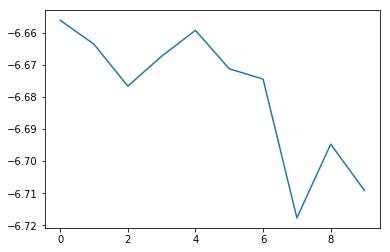

In [74]:
plt.plot(perplexity)

In [82]:
# Show some topics
for lda_model in all_models:
    for idx, topic in lda_model.print_topics(num_words=8):
        print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')
    print('\n')
    print('\n')

Topic: 0 
Words: 0.042*"algorithm" + 0.024*"optim" + 0.019*"problem" + 0.016*"gradient" + 0.015*"function" + 0.015*"learn" + 0.013*"converg" + 0.012*"stochast"
Topic: 1 
Words: 0.055*"learn" + 0.021*"task" + 0.016*"model" + 0.016*"polici" + 0.013*"state" + 0.012*"problem" + 0.012*"method" + 0.011*"function"
Topic: 2 
Words: 0.068*"network" + 0.028*"neural" + 0.020*"train" + 0.012*"layer" + 0.011*"input" + 0.010*"architectur" + 0.010*"learn" + 0.010*"deep"
Topic: 3 
Words: 0.032*"learn" + 0.017*"imag" + 0.016*"data" + 0.016*"featur" + 0.016*"train" + 0.015*"label" + 0.014*"classif" + 0.012*"object"
Topic: 4 
Words: 0.025*"graph" + 0.019*"model" + 0.016*"structur" + 0.016*"imag" + 0.011*"problem" + 0.011*"algorithm" + 0.010*"cluster" + 0.010*"object"
Topic: 5 
Words: 0.025*"model" + 0.019*"signal" + 0.014*"neural" + 0.012*"visual" + 0.011*"imag" + 0.011*"spike" + 0.011*"cod" + 0.009*"respons"
Topic: 6 
Words: 0.020*"neuron" + 0.019*"model" + 0.009*"inform" + 0.009*"decis" + 0.008*"spike"

In [28]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [29]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.020*"method" + 0.018*"propos" + 0.017*"data" + 0.017*"optim" + 0.015*"learn" + 0.013*"model" + 0.013*"approach" + 0.010*"base" + 0.010*"approxim" + 0.010*"statist"
Topic: 1 
Words: 0.022*"learn" + 0.016*"time" + 0.015*"optim" + 0.015*"result" + 0.015*"model" + 0.014*"data" + 0.013*"provid" + 0.012*"method" + 0.012*"function" + 0.012*"task"
Topic: 2 
Words: 0.032*"model" + 0.031*"learn" + 0.017*"class" + 0.015*"label" + 0.013*"gener" + 0.013*"result" + 0.013*"network" + 0.013*"output" + 0.011*"base" + 0.011*"propos"
Topic: 3 
Words: 0.027*"optim" + 0.021*"tree" + 0.020*"decis" + 0.020*"function" + 0.019*"descent" + 0.018*"model" + 0.017*"gradient" + 0.016*"convex" + 0.014*"method" + 0.014*"base"
Topic: 4 
Words: 0.070*"model" + 0.021*"gener" + 0.016*"network" + 0.016*"learn" + 0.014*"data" + 0.013*"variabl" + 0.011*"infer" + 0.010*"method" + 0.009*"distribut" + 0.009*"latent"
Topic: 5 
Words: 0.023*"gradient" + 0.023*"stochast" + 0.023*"method" + 0.018*"estim" + 0.017

-5.934519903274455